# Calculating Slope and Aspect from DEM Data

Author: Matt Oakley

## About

One of the most useful forms of geospatial data currently used is Digital Elevation Model (DEM) data. DEM data is a digital model or 3D representaion of a terrain's surface such as the Earth. Typically, DEM data can be represented as a raster which is most easily expressed as being a 2D array with each individual cell having a value (in our case this value is elevation) associated with it. 

With this data, we are able to use programs in order to analyze certain physical aspects about the area associated with the data. This tutorial will go over how we compute the **slope** and **aspect** of an area using DEM data.

## Objectives

- Read in DEM data
- Compute the slope for the entirety of the data
- Compute the aspect for the entirety of the data
- Output a PNG image visualizing the slope of the terrain
- Output a PNG image visualizing the aspect of the terrain

## Dependencies

- OGR/GDAL
- NumPy
- matplotlib

In [1]:
#Installing Dependencies

!conda install gdal

Fetching package metadata .......
Solving package specifications: ..........

# All requested packages already installed.
# packages in environment at /home/user/anaconda2:
#
gdal                      2.0.0                    py27_1  


In [2]:
#Import Statements

from __future__ import division
from osgeo import gdal
from matplotlib.colors import ListedColormap
from matplotlib import colors
import sys
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

## Read in DEM Data

Our first objective is to read in the DEM data we've acquired. For this tutorial we'll be using DEM data of the Colorado Front Range area. We'll use gdal in order to open this file and NumPy to convert the raster object into a 2D NumPy array.

In [3]:
#Open the front_range.dem file using gdal
filename = 'front_range.dem'
data = gdal.Open(filename)

#Convert the raster object to a 2D numpy array
data_array = np.array(data.GetRasterBand(1).ReadAsArray())

## Computing Slope

Now that we've read in the DEM data and converted it to a 2D NumPy array, we're able to start doing computation on it. Our first goal is to compute the slope at each point in the 2D array. Assuming each cell has surrounding cells in the following manner:

    a | b | c
    ----------
    d | e | f 
    ----------
    g | h | q
    
    Where 'e' is the current cell we're calculating the slope for
    
We can calculate the slope for that specific cell algorithmically via the following equations:
    
    [dz/dx] = ((c + 2f + q) - (a + 2d + g)) / 8
    [dz/dy] = ((g + 2h + q) - (a + 2b + c)) / 8
    rise_run = sqrt([dz/dx]^2 + [dz/dy]^2)
    slope = ATAN(rise_run) * 57.29578

In [4]:
#Initialize a new array to store slope values
num_rows = data_array.shape[0]
num_cols = data_array.shape[1]
slope_array = np.zeros((num_rows, num_cols), dtype = int)

#Set up for loops to iterate over each cell in the 2D array
for i in range(1, num_rows - 1):
    for j in range(1, num_cols - 1):
        a = data_array[i - 1][j - 1]
        b = data_array[i - 1][j]
        c = data_array[i - 1][j + 1]
        d = data_array[i][j - 1]
        e = data_array[i][j]
        f = data_array[i][j + 1]
        g = data_array[i + 1][j - 1]
        h = data_array[i + 1][j]
        q = data_array[i + 1][j + 1]
        
        #Check to see if there are any missing values adjacent to the current cell
        val_list = [a, b, c, d, e, f, g, h, q]
        all_present = True
        for k in range(0, len(val_list)):
            if val_list[k] != -32767:
                continue
            else:
                all_present = False
        
        #If all adjacent values are present, compute the slope
        if all_present == True:
            x_deriv = (c + (2 * f) + q - a - (2 * d) - g) / 8
            y_deriv = (g + (2 * h) + q - a - (2 * b) - c) / 8
            x_deriv_squared = math.pow(x_deriv, 2)
            y_deriv_squared = math.pow(y_deriv, 2)
            
            rise_run = math.sqrt(x_deriv_squared + y_deriv_squared)
            slope = math.atan(rise_run) * 57.29578
            
            slope_array[i][j] = slope
        
        #Otherwise, input 0 (missing value) for that cell
        else:
            slope_array[i][j] = 0

## Computing Aspect

Now that we have a new array, slope_array, which has the slope values we computed for each cell, we can do the same thing but for aspect. We can do this very similarly to how we calculated slope but with a few minor tweaks in the algorithm used. Assuming each cell has the same structure as before, we can calculate the aspect for each individual cell via the following equations:

    [dz/dx] = ((c + 2f + q) - (a + 2d + g)) / 8
    [dz/dy] = ((g + 2h + q) - (a + 2b + c)) / 8
    aspect = atan2([dz/dy], -[dz/dx])
    
    if aspect < 0:
        cell = 90 - aspect
    else if aspect > 90:
        cell = 360 - aspect + 90
    else:
        cell = 90 - aspect

In [5]:
#Initialize a new array to store aspect values
num_rows = data_array.shape[0]
num_cols = data_array.shape[1]
aspect_array = np.zeros((num_rows, num_cols), dtype = int)

#Set up for loops to iterate over each cell in the 2D array
for i in range(1, num_rows - 1):
    for j in range(1, num_cols - 1):
        a = data_array[i - 1][j - 1]
        b = data_array[i - 1][j]
        c = data_array[i - 1][j + 1]
        d = data_array[i][j - 1]
        e = data_array[i][j]
        f = data_array[i][j + 1]
        g = data_array[i + 1][j - 1]
        h = data_array[i + 1][j]
        q = data_array[i + 1][j + 1]
        
        #Check to see if there are any missing values adjacent to the current cell
        val_list = [a, b, c, d, e, f, g, h, q]
        all_present = True
        for k in range(0, len(val_list)):
            if val_list[k] != -32767:
                continue
            else:
                all_present = False
        
        #If all adjacent values are present, compute the aspect
        if all_present == True:
            x_deriv = (c + (2 * f) + q - a - (2 * d) - g) / 8
            y_deriv = (g + (2 * h) + q - a - (2 * b) - c) / 8
            aspect = math.atan2(y_deriv, (-1 * x_deriv)) * 57.29578
            
            if aspect < 0:
                aspect_array[i][j] = 90 - aspect
            elif aspect > 90:
                aspect_array[i][j] = 360 - aspect + 90
            else:
                aspect_array[i][j] = 90 - aspect
        
        #Otherwise, input 0 (missing value) for that cell
        else:
            aspect_array[i][j] = 0

## Visualizing Slope

We've now done all the computation that we need to do - time to see the results! In order to visualize slope, our algorithm stored the values (in degrees) of the slope at each individual cell. Therefore, we can easily visualize this via matplotlib by assigning color ranges to the values present (0 through 90). Let's do this by having values towards the bottom of our range have a green color and the progress to a red color as the values grow larger.

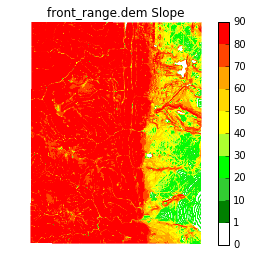

In [6]:
#Set up the colors and colorbar associated with the slope visualization
color_map = ListedColormap(['white', 'green', 'limegreen', 'lime', 'greenyellow',
                           'yellow', 'gold', 'orange', 'orangered', 'red'])
color_bounds = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90]
color_norm = colors.BoundaryNorm(color_bounds, color_map.N)

#Create the plot and colorbar
img = plt.imshow(slope_array, cmap = color_map, norm = color_norm)
cbar = plt.colorbar(img, cmap = color_map, norm = color_norm,
                   boundaries = color_bounds, ticks = color_bounds)

#Show the visualization
plt.axis('off')
plt.title(filename + " Slope")
plt.show()
plt.close()

## Visualizing Aspect

This is the exact same process as visualizing slope but with a few minor tweaks in regards to our colors and colorbar. We calculated aspect so we can see the cardinal direction that each cell is facing. Therefore, we'll have to adjust our color scheme to show which color is associated with each cardinal direction.

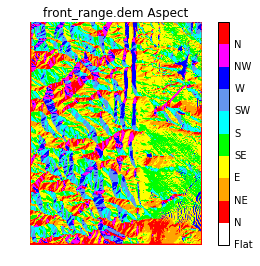

In [7]:
#Set up the colors and colorbar associated the aspect visualization
color_map = ListedColormap(['white', 'red', 'orange', 'yellow', 'lime', 'cyan',
                           'cornflowerblue', 'blue', 'magenta', 'red'])
color_bounds = [-1, 0, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 360]
color_norm = colors.BoundaryNorm(color_bounds, color_map.N)

#Create the plot and colorbar
img = plt.imshow(aspect_array, cmap = color_map, norm = color_norm)
cbar = plt.colorbar(img, cmap = color_map, norm = color_norm,
                   boundaries = color_bounds, ticks = color_bounds)
cbar.ax.tick_params(length = 0, pad = 5)
cbar.ax.set_yticklabels(['Flat', 'N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])

#Show the visualization
plt.axis('off')
plt.title(filename + " Aspect")
plt.show()
plt.close()